In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy

In [2]:
def transformData(dataset, datainfo):
  
    # Use the column-name information to rename the columns.
    renameCol = {i:col[0] for i,col in enumerate(datainfo)}
  
    # Rename
    dataset = dataset.rename(columns=renameCol)
  
    # Use the datatype information to convert the arrays back to the right datatype.
    dt = {col[0]:str if col[1] == 'object' else col[1] for col in datainfo}

    # Convert the datatypes
    dataset = dataset.astype(dt)

    # Strip the string-type arrays for the unintended characters.
    for ele in datainfo:
        # if the datatype is string, we need to do some additional conversion.
        if ele[1] == 'object':

            dataset[ele[0]] = list(map(f,dataset[ele[0]]))

            if 'date' in ele[0].lower():
                dataset[ele[0]] = dataset[ele[0]].astype(np.datetime64) 

    return dataset

# We create a function to clean the string-type arrays
f = lambda a: re.split('[\']',a)[1]

# Reading in data, LOBSTER as well as TAQ

## TAQ

In [3]:
print(os.listdir())
path = 'a:/taqhdf5'
allFiles = os.listdir(path)

['.git', '.ipynb_checkpoints', 'CrunchTAQ.ipynb', 'README.md']


In [4]:
allFiles

['taq_19930315.h5',
 'taq_19930104.h5',
 'taq_19930317.h5',
 'taq_19930105.h5',
 'taq_19930316.h5',
 'taq_19930106.h5',
 'taq_19930318.h5',
 'taq_19930107.h5',
 'taq_19930319.h5',
 'taq_19930108.h5',
 'taq_19930322.h5',
 'taq_19930111.h5',
 'taq_19930331.h5',
 'taq_19930112.h5',
 'taq_19930401.h5',
 'taq_19930113.h5',
 'taq_19930402.h5',
 'taq_19930114.h5',
 'taq_19930405.h5',
 'taq_19930115.h5',
 'taq_19930406.h5',
 'taq_19930118.h5',
 'taq_19930407.h5',
 'taq_19930119.h5',
 'taq_19930408.h5',
 'taq_19930120.h5',
 'taq_19930412.h5',
 'taq_19930121.h5',
 'taq_19930413.h5',
 'taq_19930122.h5',
 'taq_19930414.h5',
 'taq_19930125.h5',
 'taq_19930415.h5',
 'taq_19930126.h5',
 'taq_19930416.h5',
 'taq_19930127.h5',
 'taq_19930419.h5',
 'taq_19930128.h5',
 'taq_19930420.h5',
 'taq_19930129.h5',
 'taq_19930421.h5',
 'taq_19930201.h5',
 'taq_19930422.h5',
 'taq_19930202.h5',
 'taq_19930423.h5',
 'taq_19930203.h5',
 'taq_19930426.h5',
 'taq_19930204.h5',
 'taq_19930427.h5',
 'taq_19930205.h5',


In [6]:
allFiles[-10:]

['taqquote_20200417.h5',
 'taqquote_20200420.h5',
 'taqquote_20200421.h5',
 'taqquote_20200422.h5',
 'taqquote_20200423.h5',
 'taqquote_20200424.h5',
 'taqquote_20200427.h5',
 'taqquote_20200428.h5',
 'taqquote_20200429.h5',
 'taqquote_20200430.h5']

In [7]:
# Reducing the period we considered.
monthYear = [ele for ele in allFiles if '202004' in ele]#'201206'
monthYear = {ele:i for i,ele in enumerate(monthYear)}
# Separating trade and quote files.
trade = [ele for ele in monthYear.keys() if 'trade' in ele]
quote = [ele for ele in monthYear.keys() if 'quote' in ele]

In [8]:
monthYear

{'taqtrade_20200401.h5': 0,
 'taqtrade_20200402.h5': 1,
 'taqtrade_20200403.h5': 2,
 'taqtrade_20200406.h5': 3,
 'taqtrade_20200407.h5': 4,
 'taqtrade_20200408.h5': 5,
 'taqtrade_20200409.h5': 6,
 'taqtrade_20200413.h5': 7,
 'taqtrade_20200414.h5': 8,
 'taqtrade_20200415.h5': 9,
 'taqtrade_20200416.h5': 10,
 'taqtrade_20200417.h5': 11,
 'taqtrade_20200420.h5': 12,
 'taqtrade_20200421.h5': 13,
 'taqtrade_20200422.h5': 14,
 'taqtrade_20200423.h5': 15,
 'taqtrade_20200424.h5': 16,
 'taqtrade_20200427.h5': 17,
 'taqtrade_20200428.h5': 18,
 'taqtrade_20200429.h5': 19,
 'taqtrade_20200430.h5': 20,
 'taqquote_20200401.h5': 21,
 'taqquote_20200402.h5': 22,
 'taqquote_20200403.h5': 23,
 'taqquote_20200406.h5': 24,
 'taqquote_20200407.h5': 25,
 'taqquote_20200408.h5': 26,
 'taqquote_20200409.h5': 27,
 'taqquote_20200413.h5': 28,
 'taqquote_20200414.h5': 29,
 'taqquote_20200415.h5': 30,
 'taqquote_20200416.h5': 31,
 'taqquote_20200417.h5': 32,
 'taqquote_20200420.h5': 33,
 'taqquote_20200421.h5':

In [9]:
raw_data = h5py.File(path+'/'+list(monthYear.keys())[0],'r')#trade[1]#

In [10]:
raw_data.keys()

<KeysViewHDF5 ['TradeIndex', 'Trades']>

In [11]:
# Store the trade and quote indecies
TI = raw_data['TradeIndex']
#QI = raw_data['QuoteIndex']

In [12]:
# Extraxt the one we need
# i = [i for i,ele in enumerate(QI) if ele[0].astype(str).strip() == 'GOOG'][0]
j = [i for i,ele in enumerate(TI) if ele[0].astype(str).strip() == 'GOOG'][0]

In [23]:
# Seeing what we got
QI[i]

(b'GOOG      ', 261592287, 265374)

In [13]:
# Seeing what we got
TI[j]

(b'GOOG            ', 26900500, 71427)

In [14]:
# Extracting the data
# googQ = raw_data['Quotes'][np.arange(QI[i][1],QI[i][1]+QI[i][2])]
googT = raw_data['Trades'][np.arange(TI[j][1],TI[j][1]+TI[j][2])]

In [71]:
googQ

array([(14400, 0, 573.01, 1, 577.41, 2, 12, b'P'),
       (14405, 0, 573.01, 1, 590.  , 3, 12, b'P'),
       (14405, 0, 573.01, 1, 585.76, 1, 12, b'P'), ...,
       (72000, 0, 566.3 , 1,   0.  , 0, 12, b'T'),
       (72000, 0, 565.55, 1,   0.  , 0, 12, b'T'),
       (72000, 0,   0.  , 0,   0.  , 0, 12, b'T')],
      dtype=[('utcsec', '<u4'), ('ms', '<u2'), ('bid', '<f8'), ('bidsize', '<u4'), ('ofr', '<f8'), ('ofrsize', '<u4'), ('mode', '<u2'), ('ex', 'S1')])

In [15]:
# googQ.dtype

In [68]:
# Structing the data nicely
googQDF = pd.DataFrame([[ele.astype(str) if type(ele) is np.bytes_ else ele for ele in googQ[i]] \
                       for i in np.arange(googQ.shape[0])],
                      columns=googQ.dtype.names).astype({'ms':float,
                                                        'utcsec':float})
googTDF = pd.DataFrame([[ele.astype(str) if type(ele) is np.bytes_ else ele for ele in googT[i]] \
                       for i in np.arange(googT.shape[0])],
                      columns=googT.dtype.names).astype({'ms':float,
                                                       'utcsec':float})

In [69]:
googQDF

,utcsec,ms,bid,bidsize,ofr,ofrsize,mode,ex
0,14400.0,0.0,573.01,1,577.41,2,12,P
1,14405.0,0.0,573.01,1,590.00,3,12,P
2,14405.0,0.0,573.01,1,585.76,1,12,P
3,14450.0,0.0,573.01,1,581.95,1,12,P
4,14468.0,0.0,573.01,1,578.14,1,12,P
...,...,...,...,...,...,...,...,...
265369,72000.0,0.0,566.30,1,574.90,8,12,T
265370,72000.0,0.0,566.30,1,700.00,1,12,T
265371,72000.0,0.0,566.30,1,0.00,0,12,T
265372,72000.0,0.0,565.55,1,0.00,0,12,T


In [70]:
googTDF

,utcsec,ms,price,volume,cond,corr,g127,ex
0,30070.0,0.0,577.51,142,,0,0,D
1,34080.0,0.0,578.09,100,,0,0,Q
2,34080.0,0.0,578.09,400,,0,0,Q
3,34080.0,0.0,578.51,200,@F,0,0,Q
4,34080.0,0.0,578.50,300,@F,0,0,Q
...,...,...,...,...,...,...,...,...
15091,62398.0,0.0,565.85,100,@F,0,0,Q
15092,62709.0,0.0,565.21,132,,0,0,D
15093,62967.0,0.0,565.85,350,,0,0,Q
15094,64154.0,0.0,566.65,100,@F,0,0,P


In [72]:
googTDF[(googTDF.utcsec /1000000000 >= 34200) & (googTDF.utcsec / 1000000000 < 57600)]

,utcsec,ms,price,volume,cond,corr,g127,ex


## LOBSTER

In [29]:
cont = os.listdir('Lobster Sample')
cont

['GOOG_2012-06-21_34200000_57600000_message_1.csv',
 'GOOG_2012-06-21_34200000_57600000_message_5.csv',
 'GOOG_2012-06-21_34200000_57600000_orderbook_1.csv',
 'GOOG_2012-06-21_34200000_57600000_orderbook_5.csv',
 'LOBSTER_SampleFiles_ReadMe.txt']

In [30]:
# Reading in the two files
messages = pd.read_csv('Lobster Sample/'+cont[0],header=None,names = ['Time','Event','OrderID','Size','Price','Direction'])
orderbook = pd.read_csv('Lobster Sample/'+cont[2],header=None,names=['ask','asksize','bid','bidsize'])
# Reading in the two files for level 5
messages5 = pd.read_csv('Lobster Sample/'+cont[1],header=None,names = ['Time','Event','OrderID','Size','Price','Direction'])
orderbook5 = pd.read_csv('Lobster Sample/'+cont[3],header=None,names=['ask','asksize','bid','bidsize',
                                                                     'ask2','asksize2','bid2','bidsize2',
                                                                     'ask3','asksize3','bid3','bidsize3',
                                                                     'ask4','asksize4','bid4','bidsize4',
                                                                     'ask5','asksize5','bid5','bidsize5'])
#orderbook5 = pd.read_csv('Lobster Sample/'+cont[3],header=None)

In [31]:
messages

,Time,Event,OrderID,Size,Price,Direction
0,34200.015105,4,15818974,4,5794000,1
1,34200.059902,4,15818974,300,5794000,1
2,34200.113247,5,0,1,5795100,1
3,34200.113247,5,0,1,5795000,1
4,34200.113247,5,0,1,5794900,1
...,...,...,...,...,...,...
49477,57598.819072,5,0,200,5652400,1
49478,57598.843680,1,287107097,100,5653500,1
49479,57598.957742,4,287107097,100,5653500,1
49480,57599.320523,3,287087369,42,5655600,-1


In [32]:
orderbook

,ask,asksize,bid,bidsize
0,5802300,100,5794000,496
1,5802300,100,5794000,196
2,5802300,100,5794000,196
3,5802300,100,5794000,196
4,5802300,100,5794000,196
...,...,...,...,...
49477,5655600,242,5651200,200
49478,5655600,242,5653500,100
49479,5655600,242,5651200,200
49480,5655600,200,5651200,200


In [33]:
## Round lots sizes and down-scaled prices.
messages['roundSize'] =round(messages.Size/100)
messages['priceDS'] = messages.Price/10000

# Lets make size columns of round lots, as in the TAQ data.
orderbook['roundBidSize'] =round(orderbook.bidsize/100)
orderbook['roundAskSize'] =round(orderbook.asksize/100)
orderbook['askDS'] = orderbook.ask/10000
orderbook['bidDS'] = orderbook.bid/10000

# Comparison

In [42]:
### From Lobster webpage
# Event Type:
# 1: Submission of a new limit order
# 2: Cancellation (partial deletion of a limit order)
# 3: Deletion (total deletion of a limit order)
# 4: Execution of a visible limit order
# 5: Execution of a hidden limit order
# 6: Indicates a cross trade, e.g. auction trade
# 7: Trading halt indicator (detailed information below)
messages.loc[0:10]

,Time,Event,OrderID,Size,Price,Direction,roundSize,priceDS
0,34200.015105,4,15818974,4,5794000,1,0.0,579.40
1,34200.059902,4,15818974,300,5794000,1,3.0,579.40
2,34200.113247,5,0,1,5795100,1,0.0,579.51
3,34200.113247,5,0,1,5795000,1,0.0,579.50
4,34200.113247,5,0,1,5794900,1,0.0,579.49
5,34200.113247,5,0,1,5794800,1,0.0,579.48
6,34200.113247,4,15818974,167,5794000,1,2.0,579.40
7,34200.154178,1,16155653,100,5794000,1,1.0,579.40
8,34200.202323,1,4773921,25,5798900,-1,0.0,579.89
9,34200.203135,4,15818974,29,5794000,1,0.0,579.40


In [43]:
orderbook.loc[0:10]

,ask,asksize,bid,bidsize,roundBidSize,roundAskSize,askDS,bidDS
0,5802300,100,5794000,496,5.0,1.0,580.23,579.40
1,5802300,100,5794000,196,2.0,1.0,580.23,579.40
2,5802300,100,5794000,196,2.0,1.0,580.23,579.40
3,5802300,100,5794000,196,2.0,1.0,580.23,579.40
4,5802300,100,5794000,196,2.0,1.0,580.23,579.40
5,5802300,100,5794000,196,2.0,1.0,580.23,579.40
6,5802300,100,5794000,29,0.0,1.0,580.23,579.40
7,5802300,100,5794000,129,1.0,1.0,580.23,579.40
8,5798900,25,5794000,129,1.0,0.0,579.89,579.40
9,5798900,25,5794000,100,1.0,0.0,579.89,579.40


In [46]:
messages[messages.Event == 4].reset_index(drop=True).loc[0:10]

,Time,Event,OrderID,Size,Price,Direction,roundSize,priceDS
0,34200.015105,4,15818974,4,5794000,1,0.0,579.4
1,34200.059902,4,15818974,300,5794000,1,3.0,579.4
2,34200.113247,4,15818974,167,5794000,1,2.0,579.4
3,34200.203135,4,15818974,29,5794000,1,0.0,579.4
4,34200.203135,4,16155653,100,5794000,1,1.0,579.4
5,34200.207763,4,16167456,1,5794000,-1,0.0,579.4
6,34200.236450,4,16167632,11,5794000,1,0.0,579.4
7,34200.249457,4,16167632,29,5794000,1,0.0,579.4
8,34200.696340,4,16167632,59,5794000,1,1.0,579.4
9,34200.696340,4,16252843,12,5794000,1,0.0,579.4


In [52]:
np.unique(googTDF.utcsec)[0:100]

array([30070, 34080, 34132, 34181, 34190, 34191, 34195, 34196, 34197,
       34200, 34206, 34207, 34212, 34217, 34221, 34222, 34223, 34224,
       34225, 34226, 34227, 34228, 34229, 34230, 34232, 34233, 34237,
       34240, 34241, 34243, 34250, 34251, 34259, 34262, 34267, 34268,
       34281, 34293, 34297, 34312, 34315, 34320, 34323, 34324, 34325,
       34329, 34331, 34333, 34334, 34338, 34339, 34340, 34344, 34346,
       34348, 34353, 34365, 34368, 34372, 34375, 34376, 34384, 34385,
       34390, 34391, 34397, 34400, 34416, 34417, 34420, 34424, 34425,
       34426, 34429, 34435, 34438, 34440, 34443, 34444, 34447, 34467,
       34468, 34469, 34470, 34471, 34472, 34476, 34479, 34480, 34481,
       34482, 34485, 34486, 34488, 34492, 34500, 34501, 34504, 34506,
       34511], dtype=int64)

In [62]:
np.unique(googQDF[googQDF.utcsec>=34200].utcsec)[0:100]

array([34200, 34201, 34202, 34203, 34204, 34205, 34206, 34207, 34208,
       34209, 34210, 34211, 34212, 34213, 34214, 34215, 34216, 34217,
       34218, 34219, 34220, 34221, 34222, 34223, 34224, 34225, 34226,
       34227, 34228, 34229, 34230, 34231, 34232, 34233, 34234, 34235,
       34236, 34237, 34238, 34239, 34240, 34241, 34242, 34243, 34244,
       34245, 34246, 34247, 34248, 34249, 34250, 34251, 34252, 34253,
       34254, 34255, 34256, 34257, 34258, 34259, 34260, 34261, 34262,
       34263, 34264, 34265, 34267, 34268, 34269, 34270, 34271, 34272,
       34273, 34274, 34275, 34276, 34277, 34278, 34279, 34280, 34281,
       34283, 34284, 34285, 34286, 34287, 34288, 34290, 34293, 34295,
       34297, 34298, 34299, 34300, 34302, 34303, 34304, 34305, 34306,
       34307], dtype=int64)

In [76]:
googTDF[(googTDF.utcsec==34200)&((googTDF.ex=='Q')|(googTDF.ex=='T'))]#reset_index(drop=True).loc[0:10]#

,utcsec,ms,price,volume,cond,corr,g127,ex
20,34200.0,0.0,579.40,300,@F,0,0,Q
21,34200.0,0.0,579.40,167,,0,0,Q
22,34200.0,0.0,579.84,20129,@O,0,0,Q
23,34200.0,0.0,579.84,20129,,0,0,Q
24,34200.0,0.0,579.40,100,@F,0,0,Q
26,34200.0,0.0,579.46,100,,0,0,Q


In [85]:
googQDF[(googQDF.utcsec==34200)&((googQDF.ex=='Q')|(googQDF.ex=='T'))].reset_index(drop=True).loc[0:20]##&((googQDF.ex != 'B')&\
                                 #(googQDF.ex!='Y')&\
                                #(googQDF.ex!='Z')&\
                                #(googQDF.ex!='J')&\
                                #(googQDF.ex!='C')&\
                                #(googQDF.ex!='P'))

,utcsec,ms,bid,bidsize,ofr,ofrsize,mode,ex
0,34200.0,0.0,579.40,4,580.23,1,12,T
1,34200.0,0.0,579.40,1,580.23,1,12,T
2,34200.0,0.0,578.70,4,580.23,1,12,T
3,34200.0,0.0,579.40,1,580.23,1,12,T
4,34200.0,0.0,579.40,1,580.00,25,12,T
5,34200.0,0.0,579.12,1,580.00,25,12,T
6,34200.0,0.0,579.12,1,579.79,1,12,T
7,34200.0,0.0,579.40,1,579.79,1,12,T
8,34200.0,0.0,579.12,1,579.79,1,12,T
9,34200.0,0.0,579.12,1,579.79,2,12,T


In [87]:
np.unique(googQDF['mode'])

array([ 8, 12], dtype=int64)

In [65]:
orderbook.loc[0:10]

,ask,asksize,bid,bidsize,roundBidSize,roundAskSize,askDS,bidDS
0,5802300,100,5794000,496,5.0,1.0,580.23,579.40
1,5802300,100,5794000,196,2.0,1.0,580.23,579.40
2,5802300,100,5794000,196,2.0,1.0,580.23,579.40
3,5802300,100,5794000,196,2.0,1.0,580.23,579.40
4,5802300,100,5794000,196,2.0,1.0,580.23,579.40
5,5802300,100,5794000,196,2.0,1.0,580.23,579.40
6,5802300,100,5794000,29,0.0,1.0,580.23,579.40
7,5802300,100,5794000,129,1.0,1.0,580.23,579.40
8,5798900,25,5794000,129,1.0,0.0,579.89,579.40
9,5798900,25,5794000,100,1.0,0.0,579.89,579.40


# Appendix

## What are the share of quotes on each exchange?

In [78]:
t,c = np.unique(googQDF.ex,return_counts=True)

{i:j for i,j in zip(t,c)}

{'B': 86096,
 'C': 33964,
 'J': 2671,
 'K': 5122,
 'M': 124,
 'P': 42520,
 'T': 35491,
 'W': 944,
 'X': 17110,
 'Y': 14047,
 'Z': 27285}

## What are the share of trades on each exchange?

In [109]:
t,c = np.unique(googTDF.ex,return_counts=True)

{i:j for i,j in zip(t,c)}

{'B': 1013,
 'C': 187,
 'D': 4204,
 'J': 494,
 'K': 865,
 'P': 2610,
 'Q': 4162,
 'W': 1,
 'X': 24,
 'Y': 237,
 'Z': 1299}

In [110]:
sum(c)

15096

In [80]:
googDFNasdaq = googQDF[googQDF.ex == 'T'].reset_index(drop=True).astype({'ms':float})
googDFNasdaq

,utcsec,ms,bid,bidsize,ofr,ofrsize,mode,ex
0,25260,0.0,0.00,0,700.00,1,12,T
1,26662,0.0,574.00,1,700.00,1,12,T
2,27300,0.0,574.00,1,682.88,1,12,T
3,27594,0.0,574.00,1,580.00,1,12,T
4,27602,0.0,574.00,1,682.88,1,12,T
...,...,...,...,...,...,...,...,...
35486,72000,0.0,566.30,1,574.90,8,12,T
35487,72000,0.0,566.30,1,700.00,1,12,T
35488,72000,0.0,566.30,1,0.00,0,12,T
35489,72000,0.0,565.55,1,0.00,0,12,T


In [82]:
# Restricting the period to be within 9.30 am to 4 pm
googDFNasdaq = googDFNasdaq[(googDFNasdaq.utcsec >= 34200) & (googDFNasdaq.utcsec <= 57600)].reset_index(drop=True)
googDFNasdaq

,utcsec,ms,bid,bidsize,ofr,ofrsize,mode,ex
0,34200,0.0,579.40,4,580.23,1,12,T
1,34200,0.0,579.40,1,580.23,1,12,T
2,34200,0.0,578.70,4,580.23,1,12,T
3,34200,0.0,579.40,1,580.23,1,12,T
4,34200,0.0,579.40,1,580.00,25,12,T
...,...,...,...,...,...,...,...,...
35300,57600,0.0,564.91,1,565.50,1,12,T
35301,57600,0.0,564.90,2,565.50,1,12,T
35302,57600,0.0,564.85,2,565.50,1,12,T
35303,57600,0.0,564.85,1,565.50,1,12,T


In [83]:
t,c = np.unique(googDFNasdaq['mode'],return_counts=True)
{i:j for i,j in zip(t,c)}

{12: 35305}

In [84]:
sum([1 if (b == 0) | (o == 0) else 0 for b,o in zip(googDFNasdaq.bid,googDFNasdaq.ofr)])

0

# Lobster Data

In [89]:
messages5

,Time,Event,OrderID,Size,Price,Direction
0,34200.015105,4,15818974,4,5794000,1
1,34200.059902,4,15818974,300,5794000,1
2,34200.113247,5,0,1,5795100,1
3,34200.113247,5,0,1,5795000,1
4,34200.113247,5,0,1,5794900,1
...,...,...,...,...,...,...
112668,57599.544130,1,287157289,300,5655600,-1
112669,57599.544132,1,287157290,300,5655600,-1
112670,57599.544133,1,287157291,200,5655600,-1
112671,57599.544133,1,287157292,300,5655600,-1


In [90]:
### What events are presents, and what are their shares?
t,c = np.unique(messages.Event,return_counts=True)
{i:j for i,j in zip(t,c)}

{1: 24368, 2: 7, 3: 13429, 4: 7765, 5: 3913}

In [91]:
### What events are presents, and what are their shares?
t,c = np.unique(messages5.Event,return_counts=True)
{i:j for i,j in zip(t,c)}

{1: 54907, 2: 16, 3: 46072, 4: 7765, 5: 3913}

In [93]:
messages = messages[(messages.Event == 1) |(messages.Event == 4) |(messages.Event == 5) ].reset_index()
messages5 = messages5[(messages5.Event == 1) |(messages5.Event == 4) |(messages5.Event == 5) ].reset_index()

In [94]:
messages

,index,Time,Event,OrderID,Size,Price,Direction,roundSize,priceDS
0,0,34200.015105,4,15818974,4,5794000,1,0.0,579.40
1,1,34200.059902,4,15818974,300,5794000,1,3.0,579.40
2,2,34200.113247,5,0,1,5795100,1,0.0,579.51
3,3,34200.113247,5,0,1,5795000,1,0.0,579.50
4,4,34200.113247,5,0,1,5794900,1,0.0,579.49
...,...,...,...,...,...,...,...,...,...
36041,49476,57598.675338,4,287091827,188,5653000,1,2.0,565.30
36042,49477,57598.819072,5,0,200,5652400,1,2.0,565.24
36043,49478,57598.843680,1,287107097,100,5653500,1,1.0,565.35
36044,49479,57598.957742,4,287107097,100,5653500,1,1.0,565.35


In [95]:
messages5

,index,Time,Event,OrderID,Size,Price,Direction
0,0,34200.015105,4,15818974,4,5794000,1
1,1,34200.059902,4,15818974,300,5794000,1
2,2,34200.113247,5,0,1,5795100,1
3,3,34200.113247,5,0,1,5795000,1
4,4,34200.113247,5,0,1,5794900,1
...,...,...,...,...,...,...,...
66580,112667,57599.544126,1,287157288,300,5655600,-1
66581,112668,57599.544130,1,287157289,300,5655600,-1
66582,112669,57599.544132,1,287157290,300,5655600,-1
66583,112670,57599.544133,1,287157291,200,5655600,-1


In [97]:
orderbook = orderbook.loc[messages['index']].reset_index(drop=True)
orderbook

,ask,asksize,bid,bidsize
0,5802300,100,5794000,496
1,5802300,100,5794000,196
2,5802300,100,5794000,196
3,5802300,100,5794000,196
4,5802300,100,5794000,196
...,...,...,...,...
36041,5655600,242,5651200,200
36042,5655600,242,5651200,200
36043,5655600,242,5653500,100
36044,5655600,242,5651200,200


In [98]:
orderbook5 = orderbook5.loc[messages5['index']].reset_index(drop=True)
orderbook5

,ask,asksize,bid,bidsize,ask2,asksize2,bid2,bidsize2,ask3,asksize3,bid3,bidsize3,ask4,asksize4,bid4,bidsize4,ask5,asksize5,bid5,bidsize5
0,5802300,100,5794000,496,5804300,100,5787000,400,5805000,100,5785000,500,5806300,100,5780000,500,5806700,100,5771800,100
1,5802300,100,5794000,196,5804300,100,5787000,400,5805000,100,5785000,500,5806300,100,5780000,500,5806700,100,5771800,100
2,5802300,100,5794000,196,5804300,100,5787000,400,5805000,100,5785000,500,5806300,100,5780000,500,5806700,100,5771800,100
3,5802300,100,5794000,196,5804300,100,5787000,400,5805000,100,5785000,500,5806300,100,5780000,500,5806700,100,5771800,100
4,5802300,100,5794000,196,5804300,100,5787000,400,5805000,100,5785000,500,5806300,100,5780000,500,5806700,100,5771800,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66580,5652200,42,5651200,200,5655000,200,5651100,100,5655600,1600,5651000,100,5655700,100,5650200,700,5656000,100,5650000,5
66581,5652200,42,5651200,200,5655000,200,5651100,100,5655600,1900,5651000,100,5655700,100,5650200,700,5656000,100,5650000,5
66582,5652200,42,5651200,200,5655000,200,5651100,100,5655600,2200,5651000,100,5655700,100,5650200,700,5656000,100,5650000,5
66583,5652200,42,5651200,200,5655000,200,5651100,100,5655600,2400,5651000,100,5655700,100,5650200,700,5656000,100,5650000,5


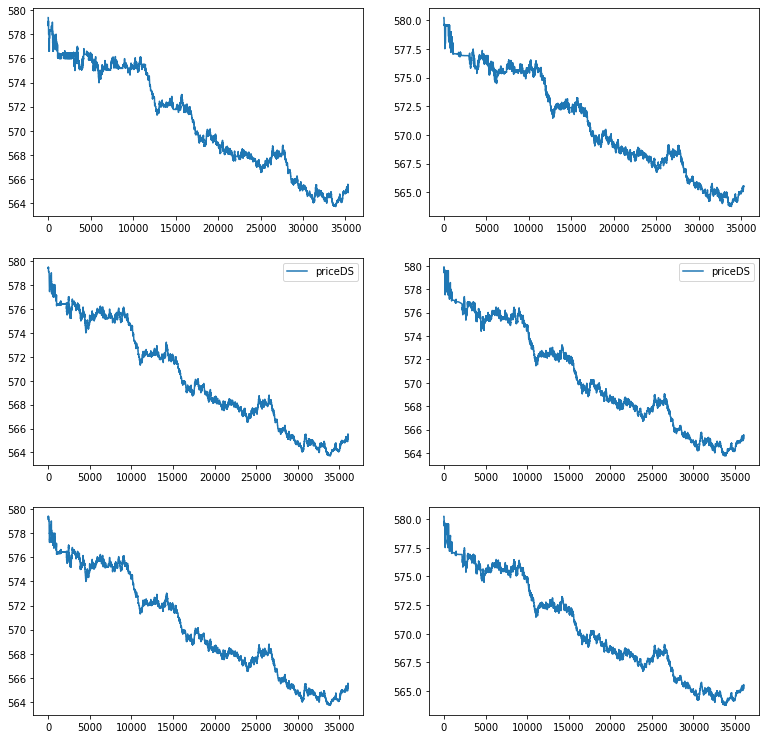

In [107]:
fig = plt.figure(figsize=(13,13))


# Divide the figure into a 2x2 grid
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

googDFNasdaq.bid.plot(ax=ax1)#[5:-5]
googDFNasdaq.ofr.plot(ax=ax2)#[5:-5]
messages[messages.Direction == 1][['priceDS']].plot(ax=ax3)
messages[messages.Direction == -1][['priceDS']].plot(ax=ax4)
orderbook.bidDS.plot(ax=ax5)
orderbook.askDS.plot(ax=ax6)
#orderbook.roundBidSize.plot(ax=ax3)
#orderbook.roundAskSize.plot(ax=ax4)

### Visualisation of Sizes

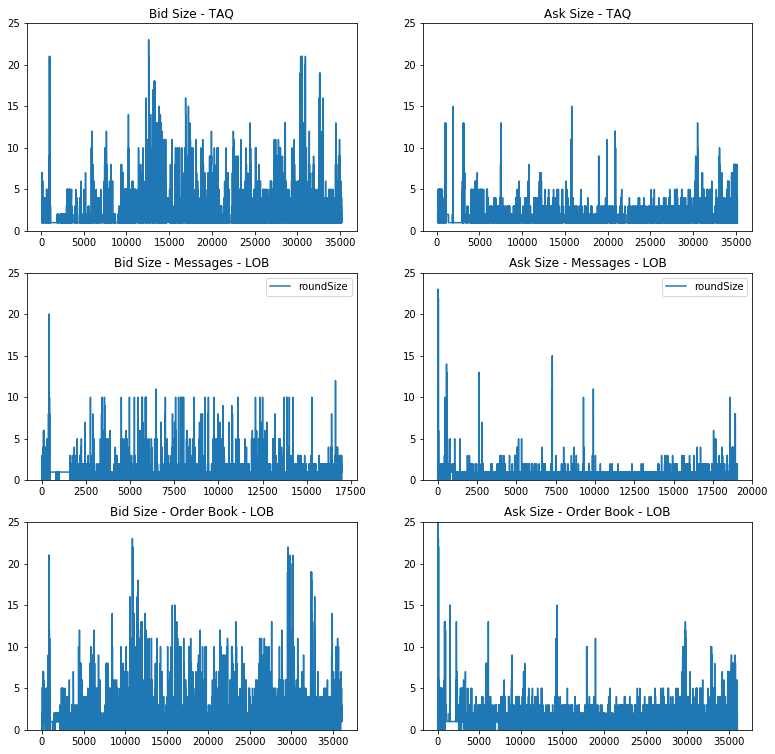

In [101]:
fig = plt.figure(figsize=(13,13))


# Divide the figure into a 2x2 grid
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

googDFNasdaq.bidsize[100:-100].plot(ax=ax1,title=('Bid Size - TAQ'))#[5:-5]
googDFNasdaq.ofrsize[100:-100].plot(ax=ax2,title=('Ask Size - TAQ'))#[5:-5]
messages[messages.Direction == 1][['roundSize']].reset_index(drop=True).plot(ax=ax3,title=('Bid Size - Messages - LOB'))
messages[messages.Direction == -1][['roundSize']].reset_index(drop=True).plot(ax=ax4,title=('Ask Size - Messages - LOB'))
orderbook.roundBidSize.plot(ax=ax5,title=('Bid Size - Order Book - LOB'))
orderbook.roundAskSize.plot(ax=ax6,title=('Ask Size - Order Book - LOB'))

ax1.set_ylim(0,25)
ax2.set_ylim(0,25)
ax3.set_ylim(0,25)
ax4.set_ylim(0,25)
ax5.set_ylim(0,25)
ax6.set_ylim(0,25)

plt.show()

In [102]:
messages.columns

Index(['index', 'Time', 'Event', 'OrderID', 'Size', 'Price', 'Direction',
       'roundSize', 'priceDS'],
      dtype='object')

In [103]:
messages['limit_order'] = [0 if (((((mp<=bbp) & (md==1)) | ((mp>=bap) & (md==-1))) & ((mt == 4) | (mt == 5)))) else 1 for mp,md,mt,bap,bbp in zip(np.array(messages['Price']),
                                                                                                                                            np.array(messages['Direction']),
                                                                                                                                            np.array(messages['Event']),
                                                                                                                                            np.array(orderbook['ask']),
                                                                                                                                            np.array(orderbook['bid']))]
messages['cancellation'] = [1 if ((mt == 2) | (mt == 3)) else 0 for mt in np.array(messages['Event'])]

## Order types extended
# Market Order, Ask: 0
# Market Order, Bid: 1
# Limit Order, Ask: 2
# Limit Order, Bid: 3
# Cancellation, Ask: 4
# Cancellation, Bid: 5
otE = []
lo, ca, dt = np.array(messages['limit_order']),np.array(messages['cancellation']),np.array(messages['Direction'])
for l,c,d in zip(lo,ca,dt):
    if (l == 0) & (d == -1) & (c == 0):
        otE.append(0)
    elif (l == 0) & (d == 1) & (c == 0):
        otE.append(1)
    elif (l == 1) & (d == -1) & (c == 0):
        otE.append(2)
    elif (l == 1) & (d == 1) & (c == 0):
        otE.append(3)
    elif (c == 1) & (d == -1):
        otE.append(4)
    elif (c == 1) & (d == 1):
        otE.append(5)

messages['type_extended'] = otE

In [104]:
messages5['limit_order'] = [0 if (((((mp<=bbp) & (md==1)) | ((mp>=bap) & (md==-1))) & ((mt == 4) | (mt == 5)))) else 1 for mp,md,mt,bap,bbp in zip(np.array(messages5['Price']),
                                                                                                                                            np.array(messages5['Direction']),
                                                                                                                                            np.array(messages5['Event']),
                                                                                                                                            np.array(orderbook5['ask']),
                                                                                                                                            np.array(orderbook5['bid']))]
messages5['cancellation'] = [1 if ((mt == 2) | (mt == 3)) else 0 for mt in np.array(messages5['Event'])]

## Order types extended
# Market Order, Ask: 0
# Market Order, Bid: 1
# Limit Order, Ask: 2
# Limit Order, Bid: 3
# Cancellation, Ask: 4
# Cancellation, Bid: 5
otE = []
lo, ca, dt = np.array(messages5['limit_order']),np.array(messages5['cancellation']),np.array(messages5['Direction'])
for l,c,d in zip(lo,ca,dt):
    if (l == 0) & (d == -1) & (c == 0):
        otE.append(0)
    elif (l == 0) & (d == 1) & (c == 0):
        otE.append(1)
    elif (l == 1) & (d == -1) & (c == 0):
        otE.append(2)
    elif (l == 1) & (d == 1) & (c == 0):
        otE.append(3)
    elif (c == 1) & (d == -1):
        otE.append(4)
    elif (c == 1) & (d == 1):
        otE.append(5)

messages5['type_extended'] = otE

In [105]:
t,c = np.unique(messages.type_extended,return_counts=True)
{i:j for i,j in zip(t,c)}

{0: 1919, 1: 1987, 2: 17142, 3: 14998}

In [106]:
t,c = np.unique(messages5.type_extended,return_counts=True)
{i:j for i,j in zip(t,c)}

{0: 1919, 1: 1987, 2: 33333, 3: 29346}

## Lets take a closer look at the conditions/modes in the data considered

In [6]:
# Reducing the period we considered.
monthYear = [ele for ele in allFiles if '2019' in ele]
# monthYear = {ele:i for i,ele in enumerate(monthYear)}
# Separating trade and quote files.
trade = [ele for ele in monthYear if 'trade' in ele]
quote = [ele for ele in monthYear if 'quote' in ele]

In [7]:
monthYear[-5:]

['taqquote_20191224.h5',
 'taqquote_20191226.h5',
 'taqquote_20191227.h5',
 'taqquote_20191230.h5',
 'taqquote_20191231.h5']

In [13]:
start = time.time()
# Creating an empty dict to contain the information.
info = {}
exchanges = ['Q']
xInXls = lambda x : x in ['Q']

# Do you wanna see?
verbose = False

print('--------- Processed days ---------\n')

for p,(t,q) in enumerate(zip(trade[60:67],quote[60:67])):#trade[60:67],quote[60:67]
    #### Container for the daily information
    subinfo = {}
    
    if verbose:
        print('Trade file: %s\nQuote file: %s' %(t,q))
    #### Extracting the all the raw data
    raw_data_t = h5py.File(path+'/'+t,'r')
    raw_data_q = h5py.File(path+'/'+q,'r')
    
    #### Store the trade and quote indices
    TI = raw_data_t['TradeIndex']
    QI = raw_data_q['QuoteIndex']
    
    #### Extraxt the one we need
    i = [i for i,ele in enumerate(QI) if ele[0].astype(str).strip() == 'GOOG'][0]
    j = [i for i,ele in enumerate(TI) if ele[0].astype(str).strip() == 'GOOG'][0]
    
    if verbose:
        print('Trade index: %i\nQuote Index: %i' % (i,j))
        print('TI Content: %s\nQI Content: %s' % (str(TI[j]),str(QI[i])))
    
    #### Extract the ticker specific data of interest
    googQ = raw_data_q['Quotes'][np.arange(QI[i][1],QI[i][1]+QI[i][2])]
    googT = raw_data_t['Trades'][np.arange(TI[j][1],TI[j][1]+TI[j][2])]
    
    if verbose:
        print('Quote Dataset Shape,Raw: %s\nTrade Dataset Shape, Raw: %s' % (str(googQ.shape),str(googT.shape)))
    
    #### Quotes
    googQDF = pd.DataFrame([[ele.astype(str) if type(ele) is np.bytes_ else ele for ele in googQ[i]] \
                       for i in np.arange(googQ.shape[0])],
                      columns=googQ.dtype.names)
    
    # Keep only observations from the specified exchanges.
    l = list(map(xInXls,googQDF.ex))
    googQDF = googQDF.loc[l,:]
    
    if p == 0:
        print('The exchanges in the quote data is: ',np.unique(googQDF.ex))
    
    if verbose:
        print('\n',googQDf.shape)
    
    # Scaling down the time column to reflect seconds
    googQDF.loc[:,'utcsec'] = googQDF.loc[:,'utcsec'] / 1000000000
    
    # Locating those indices wihtin the normal trading hours.
    ntHours = (googQDF.utcsec >=34200) & (googQDF.utcsec < 57600)
    
    # Locating the indices outside the normal trading hours.
    outSntHours = [not i for i in ntHours]
    
    # Storing the unique modes within the normal trading hours.
    subinfo['quotesNT'] = np.unique(googQDF.loc[ntHours,'mode'])
    
    # Storing the unique modes outside the normal trading hours.
    subinfo['quotesOSNT'] = np.unique(googQDF.loc[outSntHours,'mode'])
    
    #### Trades
    googTDF = pd.DataFrame([[ele.astype(str) if type(ele) is np.bytes_ else ele for ele in googT[i]] \
                           for i in np.arange(googT.shape[0])],
                          columns=googT.dtype.names)
    
    # Keep only observations from the specified exchanges.
    l = list(map(xInXls,googTDF.ex))
    googTDF = googTDF.loc[l,:]
    
    if p == 0:
        print('The exchanges in the trade data is: ',np.unique(googTDF.ex))
    
    # Scaling down the time column to reflect seconds
    googTDF.loc[:,'utcsec'] = googTDF.loc[:,'utcsec'] / 1000000000
    
    # Locating those indices wihtin the normal trading hours.
    ntHours = (googTDF.utcsec >=34200) & (googTDF.utcsec < 57600)
    
    # Locating the indices outside the normal trading hours.
    outSntHours = [not i for i in ntHours]
    
    # Storing the unique modes within the normal trading hours.
    subinfo['tradesNT'] = np.unique(googTDF.loc[ntHours,'cond'])
    
    # Storing the unique modes outside the normal trading hours.
    subinfo['tradesOSNT'] = np.unique(googTDF.loc[outSntHours,'cond'])
    
    #### Extracting the date of the data processed.
    date = re.split("[_.]",t)[1]
        
    #### Storing the data extracted
    info[date[4:6]+date[6:]] = subinfo
    
    print('           %s' % date[4:6]+date[6:])
    
end = time.time()

print('\nThe processing took %.3f seconds.' % (end-start))

--------- Processed days ---------

The exchanges in the quote data is:  ['Q']
The exchanges in the trade data is:  ['Q']
           0329
           0401
           0402
           0403
           0404
           0405
           0408

The processing took 874.851 seconds.


In [26]:
info

{'0329': {'quotesNT': array(['R', 'Y'], dtype=object),
  'quotesOSNT': array(['L', 'R', 'Y'], dtype=object),
  'tradesNT': array(['@   ', '@  I', '@  Q', '@ TI', '@4  ', '@4 I', '@4 W', '@7 V',
         '@F  ', '@F I', '@FTI', '@O X', 'C  I', 'N  I'], dtype=object),
  'tradesOSNT': array(['@   ', '@  I', '@  M', '@ T ', '@ TI', '@ TW', '@6 X', '@FT ',
         '@FTI', 'C TI', 'N T ', 'N TI'], dtype=object)},
 '0401': {'quotesNT': array(['R', 'Y'], dtype=object),
  'quotesOSNT': array(['L', 'R', 'Y'], dtype=object),
  'tradesNT': array(['@   ', '@  I', '@  Q', '@ T ', '@ TI', '@4  ', '@4 I', '@4 W',
         '@4ZI', '@7 V', '@F  ', '@F I', '@FT ', '@FTI', '@O X', 'C  I',
         'N  I'], dtype=object),
  'tradesOSNT': array(['@  M', '@ T ', '@ TI', '@ TP', '@ TW', '@6 X', '@F I', '@FT ',
         '@FTI', 'N T ', 'N TI', 'N TW'], dtype=object)},
 '0402': {'quotesNT': array(['R', 'Y'], dtype=object),
  'quotesOSNT': array(['L', 'R', 'Y'], dtype=object),
  'tradesNT': array(['@   ', '@  I

In [23]:
janinfo = copy.deepcopy(info)

In [27]:
janinfo

{'0102': {'quotesNT': array(['R', 'Y'], dtype=object),
  'quotesOSNT': array(['L', 'R', 'Y'], dtype=object),
  'tradesNT': array(['@   ', '@  I', '@  Q', '@ T ', '@ TI', '@4  ', '@4 I', '@4 W',
         '@7 V', '@F  ', '@F I', '@FTI', '@O X', 'C  I', 'N  I'],
        dtype=object),
  'tradesOSNT': array(['@  M', '@ T ', '@ TI', '@ TP', '@ TW', '@6 X', '@FT ', '@FTI',
         'C TI', 'N T '], dtype=object)},
 '0103': {'quotesNT': array(['R', 'Y'], dtype=object),
  'quotesOSNT': array(['L', 'R', 'Y'], dtype=object),
  'tradesNT': array(['@   ', '@  I', '@  Q', '@4  ', '@4 I', '@4 W', '@7 V', '@F  ',
         '@F I', '@O X', 'C  I', 'N  I', 'R   ', 'R  I'], dtype=object),
  'tradesOSNT': array(['@  M', '@ T ', '@ TI', '@ TP', '@ TW', '@6 X', '@FT ', '@FTI',
         'N T ', 'N TI', 'N TW'], dtype=object)},
 '0104': {'quotesNT': array(['R', 'Y'], dtype=object),
  'quotesOSNT': array(['L', 'R', 'Y'], dtype=object),
  'tradesNT': array(['@   ', '@  I', '@  Q', '@ T ', '@ TI', '@4 I', '@4 W'

In [31]:
# Just for a better overview
for j in janinfo.keys():
    
    print(j,'\n')
    for ele in janinfo[j].items():
        print(ele)
    
    

0102 

('quotesNT', array(['R', 'Y'], dtype=object))
('quotesOSNT', array(['L', 'R', 'Y'], dtype=object))
('tradesNT', array(['@   ', '@  I', '@  Q', '@ T ', '@ TI', '@4  ', '@4 I', '@4 W',
       '@7 V', '@F  ', '@F I', '@FTI', '@O X', 'C  I', 'N  I'],
      dtype=object))
('tradesOSNT', array(['@  M', '@ T ', '@ TI', '@ TP', '@ TW', '@6 X', '@FT ', '@FTI',
       'C TI', 'N T '], dtype=object))
0103 

('quotesNT', array(['R', 'Y'], dtype=object))
('quotesOSNT', array(['L', 'R', 'Y'], dtype=object))
('tradesNT', array(['@   ', '@  I', '@  Q', '@4  ', '@4 I', '@4 W', '@7 V', '@F  ',
       '@F I', '@O X', 'C  I', 'N  I', 'R   ', 'R  I'], dtype=object))
('tradesOSNT', array(['@  M', '@ T ', '@ TI', '@ TP', '@ TW', '@6 X', '@FT ', '@FTI',
       'N T ', 'N TI', 'N TW'], dtype=object))
0104 

('quotesNT', array(['R', 'Y'], dtype=object))
('quotesOSNT', array(['L', 'R', 'Y'], dtype=object))
('tradesNT', array(['@   ', '@  I', '@  Q', '@ T ', '@ TI', '@4 I', '@4 W', '@7 I',
       '@7 V', '

In [32]:
# Just for a better overview
for a in info.keys():
    
    print(a,'\n')
    for ele in info[a].items():
        print(ele)
    
    

0329 

('quotesNT', array(['R', 'Y'], dtype=object))
('quotesOSNT', array(['L', 'R', 'Y'], dtype=object))
('tradesNT', array(['@   ', '@  I', '@  Q', '@ TI', '@4  ', '@4 I', '@4 W', '@7 V',
       '@F  ', '@F I', '@FTI', '@O X', 'C  I', 'N  I'], dtype=object))
('tradesOSNT', array(['@   ', '@  I', '@  M', '@ T ', '@ TI', '@ TW', '@6 X', '@FT ',
       '@FTI', 'C TI', 'N T ', 'N TI'], dtype=object))
0401 

('quotesNT', array(['R', 'Y'], dtype=object))
('quotesOSNT', array(['L', 'R', 'Y'], dtype=object))
('tradesNT', array(['@   ', '@  I', '@  Q', '@ T ', '@ TI', '@4  ', '@4 I', '@4 W',
       '@4ZI', '@7 V', '@F  ', '@F I', '@FT ', '@FTI', '@O X', 'C  I',
       'N  I'], dtype=object))
('tradesOSNT', array(['@  M', '@ T ', '@ TI', '@ TP', '@ TW', '@6 X', '@F I', '@FT ',
       '@FTI', 'N T ', 'N TI', 'N TW'], dtype=object))
0402 

('quotesNT', array(['R', 'Y'], dtype=object))
('quotesOSNT', array(['L', 'R', 'Y'], dtype=object))
('tradesNT', array(['@   ', '@  I', '@  Q', '@  W', '@ TI',

In [68]:
cont = [[],[],[],[]]

for i,j in enumerate(janinfo.keys()):
    
    for ii,ele in enumerate(janinfo[j].keys()):
        
        for subele in janinfo[j][ele]:
            if len(subele) == 1:
                #print(subele)
                cont[ii].append(subele)
            else:
                #print(subele)
                indiEles = re.split('',subele)
                cont[ii] += indiEles
                #print(indiEles)
        print(i)
        if i == len(list(janinfo.keys()))-1:
            cont[ii] = set(cont[ii])

0
0
0
0
1
1
1
1
2
2
2
2
3
3
3
3
4
4
4
4
5
5
5
5
6
6
6
6


In [71]:
for k,c in zip(janinfo[list(janinfo.keys())[0]],cont):
    print(k,': ',c)

quotesNT :  {'R', 'Y'}
quotesOSNT :  {'L', 'R', 'Y'}
tradesNT :  {'', 'T', 'C', ' ', 'R', 'Z', '7', 'F', 'W', '4', '@', 'V', 'O', 'Q', 'I', 'X', 'N'}
tradesOSNT :  {'', 'T', 'P', '6', ' ', 'C', 'R', 'F', 'W', 'M', '@', '9', 'I', 'X', 'N'}


In [75]:
# Which are in OSNT sets but not in their NT counterparts?
print('In quotesOSNT but not in quotesNT: ',cont[1].difference(cont[0]))
print('In tradesOSNT but not in tradesNT: ',cont[2].difference(cont[3]))

In quotesOSNT but not in quotesNT:  {'L'}
In tradesOSNT but not in tradesNT:  {'Z', '7', '4', 'V', 'O', 'Q'}


### How does it look for restrictied exchanges?

In [12]:
janinfoRe = copy.deepcopy(info)
janinfoRe

{'0102': {'quotesNT': array(['R'], dtype=object),
  'quotesOSNT': array(['R'], dtype=object),
  'tradesNT': array(['@   ', '@  I', '@  Q', '@ T ', '@ TI', '@F  ', '@F I', '@FTI',
         '@O X'], dtype=object),
  'tradesOSNT': array(['@  M', '@ T ', '@ TI', '@6 X', '@FT ', '@FTI'], dtype=object)},
 '0103': {'quotesNT': array(['R'], dtype=object),
  'quotesOSNT': array(['R'], dtype=object),
  'tradesNT': array(['@   ', '@  I', '@  Q', '@F  ', '@F I', '@O X'], dtype=object),
  'tradesOSNT': array(['@  M', '@ T ', '@ TI', '@6 X', '@FT ', '@FTI'], dtype=object)},
 '0104': {'quotesNT': array(['R'], dtype=object),
  'quotesOSNT': array(['R'], dtype=object),
  'tradesNT': array(['@   ', '@  I', '@  Q', '@ T ', '@ TI', '@F  ', '@F I', '@FT ',
         '@O X'], dtype=object),
  'tradesOSNT': array(['@  I', '@  M', '@ T ', '@ TI', '@6 X', '@FT ', '@FTI'],
        dtype=object)},
 '0107': {'quotesNT': array(['R'], dtype=object),
  'quotesOSNT': array(['R'], dtype=object),
  'tradesNT': array(['@

In [14]:
# Lets get the unqiue elements

cont = [[],[],[],[]]

for i,j in enumerate(janinfo.keys()):
    
    for ii,ele in enumerate(janinfo[j].keys()):
        
        for subele in janinfo[j][ele]:
            if len(subele) == 1:
                #print(subele)
                cont[ii].append(subele)
            else:
                #print(subele)
                indiEles = re.split('',subele)
                cont[ii] += indiEles
                #print(indiEles)
        print(i)
        if i == len(list(janinfo.keys()))-1:
            cont[ii] = set(cont[ii])

NameError: name 'janinfo' is not defined

In [ ]:
# Visualise the unique entities
for k,c in zip(janinfo[list(janinfo.keys())[0]],cont):
    print(k,': ',c)

In [ ]:
# Which are in OSNT sets but not in their NT counterparts?
print('In quotesOSNT but not in quotesNT: ',cont[1].difference(cont[0]))
print('In tradesOSNT but not in tradesNT: ',cont[2].difference(cont[3]))

### How does it look for the extracted data, that we read in?

In [77]:
data = h5py.File('Data_v2.hd5f','r')

In [78]:
data.keys()

<KeysViewHDF5 ['GOOG']>

In [80]:
data['GOOG'].keys().guot

<KeysViewHDF5 ['quoteDSInfo', 'quotes', 'tradeDSInfo', 'trades']>

In [87]:
# Loading in the data in a dataframe
df = pd.DataFrame(data['GOOG']['trades'][()].T)
df

,0,1,2,3,4,5,6
0,b'14539123138141',b'Q',b'@FTI',b'2',b'1020.0',b'00',b'2019-01-02'
1,b'14551173824163',b'Q',b'@FTI',b'2',b'1015.0',b'00',b'2019-01-02'
2,b'16812844835427',b'Q',b'@FTI',b'7',b'1014.36',b'00',b'2019-01-02'
3,b'16906341755757',b'Q',b'@FTI',b'10',b'1015.0',b'00',b'2019-01-02'
4,b'16906341760338',b'Q',b'@FTI',b'90',b'1014.36',b'00',b'2019-01-02'
...,...,...,...,...,...,...,...
231972,b'70916714602790',b'Q',b'@FTI',b'5',b'1112.99',b'00',b'2019-01-31'
231973,b'70958946165868',b'Q',b'@FTI',b'1',b'1114.0',b'00',b'2019-01-31'
231974,b'70958946170316',b'Q',b'@FTI',b'50',b'1114.7',b'00',b'2019-01-31'
231975,b'70958946173190',b'Q',b'@FT ',b'100',b'1114.79',b'00',b'2019-01-31'


In [88]:
# Extracting the quote-dataset information
dsInfo = np.array(data['GOOG']['tradeDSInfo']).astype(str)
# See what information is contained within.
dsInfo

array([['utcsec', 'int64'],
       ['ex', 'object'],
       ['cond', 'object'],
       ['volume', 'int64'],
       ['price', 'float64'],
       ['corr', 'object'],
       ['Date', 'object']], dtype='<U21')

In [89]:
# Transform the data back to the orignal non-compressed format.
df = transformData(df,dsInfo)
df

,utcsec,ex,cond,volume,price,corr,Date
0,14539123138141,Q,@FTI,2,1020.00,00,2019-01-02
1,14551173824163,Q,@FTI,2,1015.00,00,2019-01-02
2,16812844835427,Q,@FTI,7,1014.36,00,2019-01-02
3,16906341755757,Q,@FTI,10,1015.00,00,2019-01-02
4,16906341760338,Q,@FTI,90,1014.36,00,2019-01-02
...,...,...,...,...,...,...,...
231972,70916714602790,Q,@FTI,5,1112.99,00,2019-01-31
231973,70958946165868,Q,@FTI,1,1114.00,00,2019-01-31
231974,70958946170316,Q,@FTI,50,1114.70,00,2019-01-31
231975,70958946173190,Q,@FT,100,1114.79,00,2019-01-31


In [91]:
hold = []
for ele in np.unique(df['cond']):
    indiEle = re.split('',ele)
    
    hold += indiEle

set(hold)

{'', ' ', '6', '9', '@', 'F', 'I', 'M', 'O', 'Q', 'T', 'X'}